In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
os.environ['KAGGLE_USERNAME'] = "USERNAME"
os.environ['KAGGLE_KEY'] = "KEY"
!kaggle competitions download -c titanic

401 - Unauthorized


In [3]:
titanic = pd.read_csv("train.csv", index_col = 'PassengerId')
df_test = pd.read_csv('test.csv', index_col='PassengerId')

# Data Comprehension

In [4]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

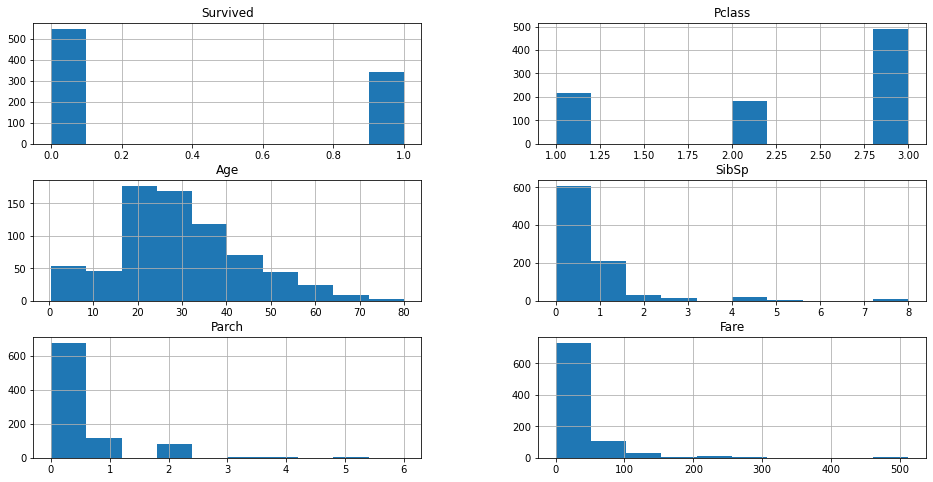

In [7]:
titanic.hist(figsize=(16,8))

## Counting different values in Ticket feature

In [8]:
titanic.Ticket.nunique()

681

## Exploring associations

<AxesSubplot:title={'center':'Barplot: Parch X Pclass '}, xlabel='Pclass', ylabel='Parch'>

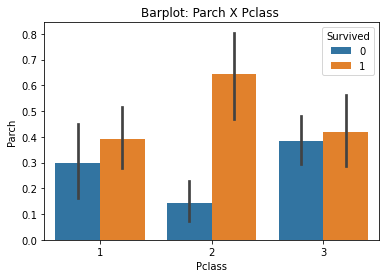

In [9]:
plt.title("Barplot: Parch X Pclass ")
sns.barplot(data=titanic,y='Parch', x='Pclass',hue='Survived')

<AxesSubplot:title={'center':'Survived X Sex'}, xlabel='Sex', ylabel='Age'>

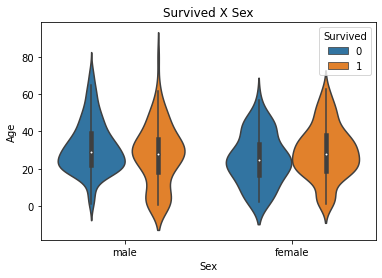

In [10]:
plt.title("Survived X Sex")
sns.violinplot(x='Sex',y='Age',hue='Survived', data=titanic)

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

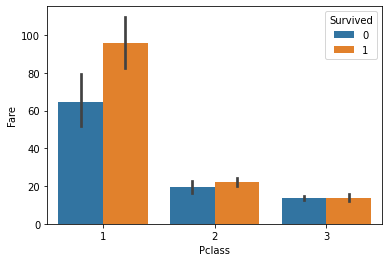

In [11]:
sns.barplot(x='Pclass', y='Fare', hue='Survived', data=titanic)

<AxesSubplot:xlabel='Parch', ylabel='SibSp'>

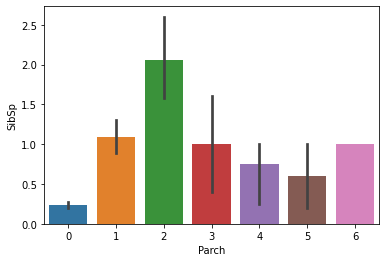

In [12]:
sns.barplot(x='Parch',y='SibSp',data=titanic)

# Preprocessing Data: Drop Useless Columns
*   The three columns cabin, name and ticket are useless because: cabin got more or less 200 values as not null, what means more than 70% of the data are empty; ticket and name got one value per input. 
*   Survived is cutted of because is what we gonna try to predict. Using it to create new features would imply in data leakage.

In [13]:
df = titanic.drop(['Cabin', 'Name', 'Ticket', 'Survived'], axis=1)
df_test = df_test.drop(['Cabin', 'Name', 'Ticket'], axis=1)

In [14]:
df.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

# Preprocessing Data: Feature Engeneering

In [15]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 95.7+ KB


In [17]:
df.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,-0.549500,0.096067,0.159651,0.216225,1.000000


In [18]:
df['Family_Size'] = df['SibSp'] + df['Parch']
df_test['Family_Size'] = df_test['SibSp'] + df_test['Parch']

In [19]:
df.drop(['SibSp', 'Parch'], axis = 1, inplace = True)
df_test.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

# Preprocessing Data: Creating Pipelines

In [20]:
num_cols = [column for column in df.columns if df[column].dtype in ['float64', 'int64']]
cat_cols = [column for column in df.columns if df[column].dtype not in ['float64', 'int64']]

In [21]:
print('Numeric Columns',num_cols)
print('Categorical Columns',cat_cols)

Numeric Columns ['Pclass', 'Age', 'Fare', 'Family_Size']
Categorical Columns ['Sex', 'Embarked']


In [52]:
X_train, X_test, y_train, y_test = train_test_split(df, titanic.Survived, test_size=0.2, random_state=42)

In [23]:
num_preprocessing = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                              ('scaler', StandardScaler())])

cat_preprocessing = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                              ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('numerical', num_preprocessing, num_cols), 
                                  ('categorical', cat_preprocessing, cat_cols)], n_jobs=4)

In [53]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Modelling
*   Naive Bayes
*   Random Forest
*   Decision Tree
*   KNN
*   Logistic Regression

## Naive Bayes

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       105
           1       0.70      0.77      0.74        74

    accuracy                           0.77       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.77      0.77       179



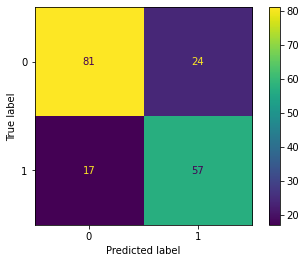

In [26]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train,y_train)
prediction = naive_bayes.predict(X_test)
print(classification_report(y_test, prediction))
plot_confusion_matrix(naive_bayes, X_test, y_test)
plt.show()

## Random Forest

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2'} 0.7531420150265136
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



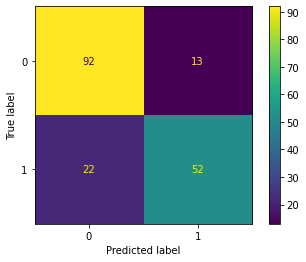

In [38]:
params = {"max_depth": [5,10,15,20,25,50],
         "criterion": ['gini', 'entropy'],
         "max_features":['auto', 'log2']}

random_forest = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, scoring='f1')
random_forest.fit(X_train,y_train)
prediction = random_forest.predict(X_test)
print(random_forest.best_params_, random_forest.best_score_)
print(classification_report(y_test, prediction))
plot_confusion_matrix(random_forest, X_test, y_test)
plt.show()

## Decision Tree

{'criterion': 'entropy', 'max_depth': 5} 0.7202578633261725
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.66      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179



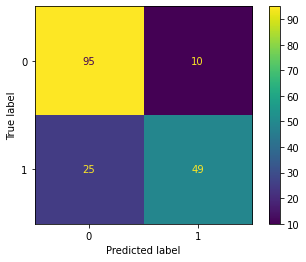

In [39]:
params = {"max_depth": [5,10,15,20,25,50],
         "criterion": ['gini', 'entropy']}

decision_tree = GridSearchCV(DecisionTreeClassifier(), params,scoring='f1')
decision_tree.fit(X_train,y_train)
prediction = decision_tree.predict(X_test)
print(decision_tree.best_params_, decision_tree.best_score_)
print(classification_report(y_test, prediction))
plot_confusion_matrix(decision_tree, X_test, y_test)
plt.show()

## KNN

{'n_neighbors': 3, 'weights': 'uniform'} 0.8033290653008963
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



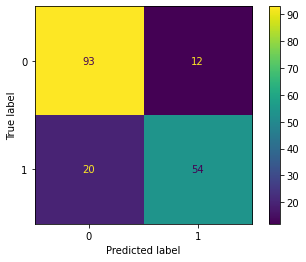

In [41]:
params = {"n_neighbors":[3,5,7],
         "weights":['uniform', 'distance']}

knn = GridSearchCV(KNeighborsClassifier(), params)
knn.fit(X_train,y_train)
prediction = knn.predict(X_test)
print(knn.best_params_, knn.best_score_)
print(classification_report(y_test, prediction))
plot_confusion_matrix(knn, X_test, y_test)
plt.show()

## Logistic Regression

{'penalty': 'l1', 'solver': 'liblinear'} 0.7962769624741456
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



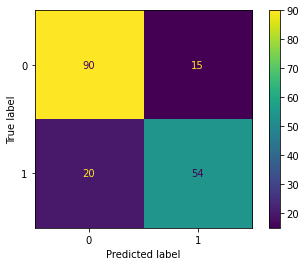

In [46]:
params = {'penalty':['l1','l2','elasticnet'],
         'solver':['newton-cg', 'lbfgs', 'liblinear']}

log_reg = GridSearchCV(LogisticRegression(), params)
log_reg.fit(X_train,y_train)
prediction = log_reg.predict(X_test)
print(log_reg.best_params_, log_reg.best_score_)
print(classification_report(y_test, prediction))
plot_confusion_matrix(log_reg, X_test, y_test)
plt.show()

## SVM

{'gamma': 'auto', 'kernel': 'rbf'} 0.8229685807150597
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



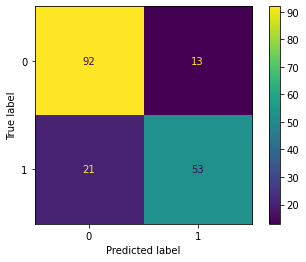

In [54]:
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
         'gamma':['scale', 'auto']}

svm = GridSearchCV(SVC(), params)
svm.fit(X_train,y_train)
prediction = svm.predict(X_test)
print(svm.best_params_, svm.best_score_)
print(classification_report(y_test, prediction))
plot_confusion_matrix(svm, X_test, y_test)
plt.show()

## Result

In [60]:
X_submission = preprocessor.transform(df_test)
y_predict = svm.predict(X_submission)

In [61]:
submission = pd.DataFrame({
    "PassengerId": df_test.index,
    "Survived": y_predict
})

In [62]:
submission.to_csv('submission.csv', index = False)